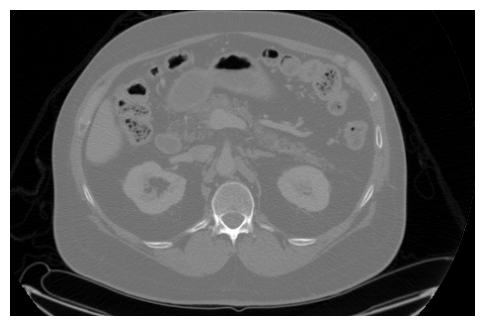

In [11]:
import nibabel as nib
import matplotlib.pyplot as plt

# 1. Load the NIfTI file
nii = nib.load('/Users/ariellubonja/prog/alans_lab/DiffTumor/data/pancreatic-tumor/BDMAP_00000541/ct.nii.gz')

# 2. Get the image data array
data = nii.get_fdata()

# 3. Extract the 60th axial slice (zero-indexed: slice 59)
axial_slice = data[:, :, 59]

# 4. Plot it
plt.figure(figsize=(6,6))
plt.imshow(axial_slice[::-1, :].T, cmap="gray", origin="lower")  # flip LR
# plt.title('Axial Slice 60')
plt.axis('off')
plt.show()

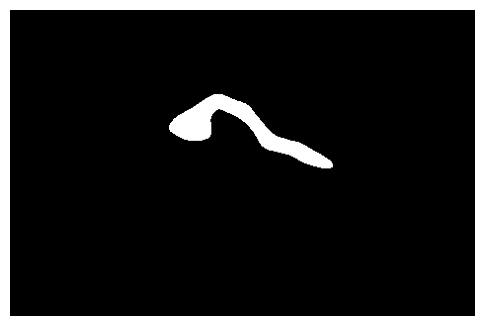

In [13]:
# 1. Load the NIfTI file
seg_nii = nib.load('/Users/ariellubonja/prog/alans_lab/DiffTumor/data/pancreatic-tumor/BDMAP_00000541/segmentations/pancreas.nii.gz')

# 2. Get the image data array
pancreas = seg_nii.get_fdata()

# 3. Extract the 60th axial slice (zero-indexed: slice 59)
pancreas_axial_slice = pancreas[:, :, 59]

# 4. Plot it
plt.figure(figsize=(6,6))
plt.imshow(axial_slice[::-1, :].T, cmap="gray", origin="lower")  # flip LR
plt.imshow(pancreas_axial_slice[::-1, :].T, cmap="gray", origin="lower")  # flip LR
# plt.title('Axial Slice 60')
plt.axis('off')
plt.show()

### Non-SVG saving of mask

Though bad prediction calculator

Done → fig_out


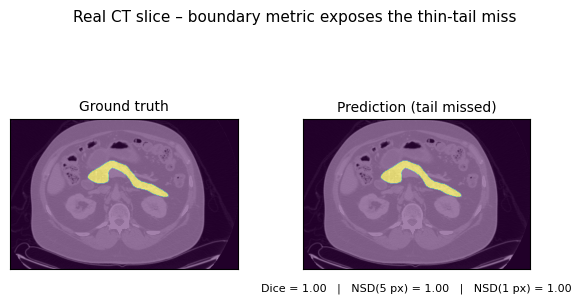

In [ ]:
#!/usr/bin/env python3
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import binary_erosion, distance_transform_edt
from pathlib import Path

# ---------- I/O ----------
ct_path   = "/Users/ariellubonja/prog/alans_lab/DiffTumor/data/pancreatic-tumor/BDMAP_00000541/ct.nii.gz"           # (optional) if you want to show anatomy underneath
gt_path   = "/Users/ariellubonja/prog/alans_lab/DiffTumor/data/pancreatic-tumor/BDMAP_00000541/segmentations/pancreas.nii.gz"      # ground-truth organ mask
out_dir   = Path("./fig_out"); out_dir.mkdir(exist_ok=True)

gt_nii = nib.load(gt_path); gt = gt_nii.get_fdata().astype(bool)   # shape (Z, Y, X)
ct     = nib.load(ct_path).get_fdata() if Path(ct_path).exists() else None

# ---------- pick a useful slice ----------
# z_best = np.argmax(gt.sum(axis=(1,2)))        # slice with max mask area
z_best=59
gt2d   = gt[:,:,z_best].T                           # 2-D boolean mask
ct2d   = ct[:,:,z_best].T if ct is not None else None

gt2d = gt2d[::-1,::-1]
ct2d = ct2d[::-1,::-1]

# ---------- forge a "bad" prediction ----------
pred2d = gt2d.copy()

# Example hack: remove a 5-px-wide stripe on the rightmost tail
# (tune these indices until a visibly thin extension is gone)
stripe = (slice(None), slice(-12, -7))        # rows : , cols −12..−8
pred2d[stripe] = False

# ---------- metric helpers ----------
def dice(a, b):
    inter = np.logical_and(a, b).sum()
    return 2*inter / (a.sum() + b.sum())

def surface_dice(a, b, tol=5):
    def border(mask):
        er = binary_erosion(mask, iterations=1)
        return np.logical_and(mask, ~er)
    Sa, Sb = border(a), border(b)
    dA = distance_transform_edt(~border(b))[Sa]
    dB = distance_transform_edt(~border(a))[Sb]
    hits = (dA <= tol).sum() + (dB <= tol).sum()
    return hits / (Sa.sum() + Sb.sum())

dsc     = dice(gt2d, pred2d)              # 2-D for visual; swap to 3-D if needed
nsd5    = surface_dice(gt2d, pred2d, 5)
nsd1    = surface_dice(gt2d, pred2d, 1)

# ---------- plot ----------
fig, axs = plt.subplots(1, 2, figsize=(6,3.2))
for ax, m, title in zip(
        axs, [gt2d, pred2d], ["Ground truth", "Prediction (tail missed)"]):
    if ct2d is not None:                 # optional grey CT underlay
        ax.imshow(ct2d, cmap="gray", vmin=np.percentile(ct2d,5),
                                   vmax=np.percentile(ct2d,99))
    ax.imshow(m, cmap="viridis", alpha=0.5)   # overlay mask
    ax.set_title(title, fontsize=10)
    ax.set_xticks([]); ax.set_yticks([])

axs[1].text(0.5, -0.09,
            f"Dice = {dsc:.2f}   |   NSD(5 px) = {nsd5:.2f}   |   NSD(1 px) = {nsd1:.2f}",
            ha="center", va="top", transform=axs[1].transAxes, fontsize=8)
fig.suptitle("Real CT slice – boundary metric exposes the thin-tail miss",
             fontsize=11, y=1.03)

fig.tight_layout()
# fig.savefig(out_dir/"organ_tail_demo.svg",  bbox_inches="tight")
# fig.savefig(out_dir/"organ_tail_demo.pdf",  bbox_inches="tight")
print("Done →", out_dir)

## Converting Boolean to SVG!

In [ ]:
fig, ax = plt.subplots(figsize=(4,4))
ax.contourf(gt2d[::-1, :], levels=[0.5, 1.5], colors=["#1f77b4"])  # solid fill
ax.set(aspect="equal", xticks=[], yticks=[], frame_on=False)

out = Path("figures/fig_mask")
fig.savefig(out.with_suffix(".svg"),  bbox_inches="tight")  # pure vector
fig.savefig(out.with_suffix(".pdf"), bbox_inches="tight")  # journal-ready
plt.close(fig)
